In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchsummary import summary

from tqdm import tqdm

from PIL import Image
Image.MAX_IMAGE_PIXELS = 120000000

In [2]:
# Load the data using ImageFolder
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_dataset = torchvision.datasets.ImageFolder(root='./images', transform=data_transform)

In [3]:
# Split the data into training, validation and testing sets
train_size = int(0.5 * len(image_dataset))
val_size = int(0.25 * len(image_dataset))
test_size = len(image_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size, test_size])

In [4]:
# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=6)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=6)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=6)

# Set up dict for dataloaders
dataloaders = {'train': train_loader,
               'val': val_loader,
               'test': test_loader}

In [5]:
# Store size of training and validation sets
dataset_sizes = {'train': len(train_dataset),
                 'val': len(val_dataset),
                 'test': len(test_dataset)}

print(dataset_sizes)

# Get class names associated with labels
class_names = image_dataset.classes
print(class_names)

{'train': 21542, 'val': 10771, 'test': 10771}
['neutral', 'nsfw']


In [8]:
# Load the ResNet152 model
model = torchvision.models.resnet152(pretrained=True)

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = True

# Replace the final fully-connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [512, 64, 112, 112]           9,408
       BatchNorm2d-2        [512, 64, 112, 112]             128
              ReLU-3        [512, 64, 112, 112]               0
         MaxPool2d-4          [512, 64, 56, 56]               0
            Conv2d-5          [512, 64, 56, 56]           4,096
       BatchNorm2d-6          [512, 64, 56, 56]             128
              ReLU-7          [512, 64, 56, 56]               0
            Conv2d-8          [512, 64, 56, 56]          36,864
       BatchNorm2d-9          [512, 64, 56, 56]             128
             ReLU-10          [512, 64, 56, 56]               0
           Conv2d-11         [512, 256, 56, 56]          16,384
      BatchNorm2d-12         [512, 256, 56, 56]             512
           Conv2d-13         [512, 256, 56, 56]          16,384
      BatchNorm2d-14         [512, 256,

In [10]:
# Display a summary of the layers of the model and output shape after each layer
images, labels = next(iter(train_loader))
summary(model,(images.shape[1:]),batch_size=16,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 112, 112]           9,408
       BatchNorm2d-2         [16, 64, 112, 112]             128
              ReLU-3         [16, 64, 112, 112]               0
         MaxPool2d-4           [16, 64, 56, 56]               0
            Conv2d-5           [16, 64, 56, 56]           4,096
       BatchNorm2d-6           [16, 64, 56, 56]             128
              ReLU-7           [16, 64, 56, 56]               0
            Conv2d-8           [16, 64, 56, 56]          36,864
       BatchNorm2d-9           [16, 64, 56, 56]             128
             ReLU-10           [16, 64, 56, 56]               0
           Conv2d-11          [16, 256, 56, 56]          16,384
      BatchNorm2d-12          [16, 256, 56, 56]             512
           Conv2d-13          [16, 256, 56, 56]          16,384
      BatchNorm2d-14          [16, 256,

In [6]:
device =  "cpu"
if torch.cuda.is_available():
    device = "cuda"
    
# Move the model to the GPU
device = torch.device(device)
model = model.to(device)

NameError: name 'model' is not defined

In [11]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Learning rate scheduler - decay LR by a factor of 0.1 every 7 epochs
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Keep track of the best model's performance on the validation set
best_acc = 0.0
best_model_wts = model.state_dict()

In [12]:
def train_model(model, criterion, optimizer, dataloaders, scheduler=None, device="cpu", num_epochs=25):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            batch_count = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                
                if batch_count % 10 == 0 and phase == 'train':
                    print('Batch {}/{}'.format(batch_count, len(dataloaders[phase])))
                    
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)
                
                batch_count += 1

            # Step along learning rate scheduler when in train
            if phase == 'train':
                if scheduler != None:
                    scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # If model performs better on val set, save weights as the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:3f}'.format(best_acc))

    # Load the weights from best model
    model.load_state_dict(best_model_wts)

    return model

In [13]:
#Train the model
model = train_model(model = model, criterion = criterion, optimizer = optimizer, dataloaders = dataloaders, device = device, num_epochs=5)

Epoch 0/4
----------
Batch 0/43
Batch 10/43
Batch 20/43
Batch 30/43
Batch 40/43
train Loss: 0.3525 Acc: 0.8577
val Loss: 0.2440 Acc: 0.9066

Epoch 1/4
----------
Batch 0/43
Batch 10/43
Batch 20/43
Batch 30/43
Batch 40/43
train Loss: 0.2270 Acc: 0.9178
val Loss: 0.2251 Acc: 0.9149

Epoch 2/4
----------
Batch 0/43
Batch 10/43
Batch 20/43
Batch 30/43
Batch 40/43
train Loss: 0.2115 Acc: 0.9235
val Loss: 0.2135 Acc: 0.9218

Epoch 3/4
----------
Batch 0/43
Batch 10/43
Batch 20/43
Batch 30/43
Batch 40/43
train Loss: 0.2049 Acc: 0.9257
val Loss: 0.2116 Acc: 0.9215

Epoch 4/4
----------
Batch 0/43
Batch 10/43
Batch 20/43
Batch 30/43
Batch 40/43
train Loss: 0.2012 Acc: 0.9263
val Loss: 0.2083 Acc: 0.9219

Training complete in 39m 17s
Best val Acc: 0.921920


In [14]:
torch.save(model, './model/best_model_152_full.pt')

In [17]:
trained_model = torch.load('./model/best_model.pt')
trained_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

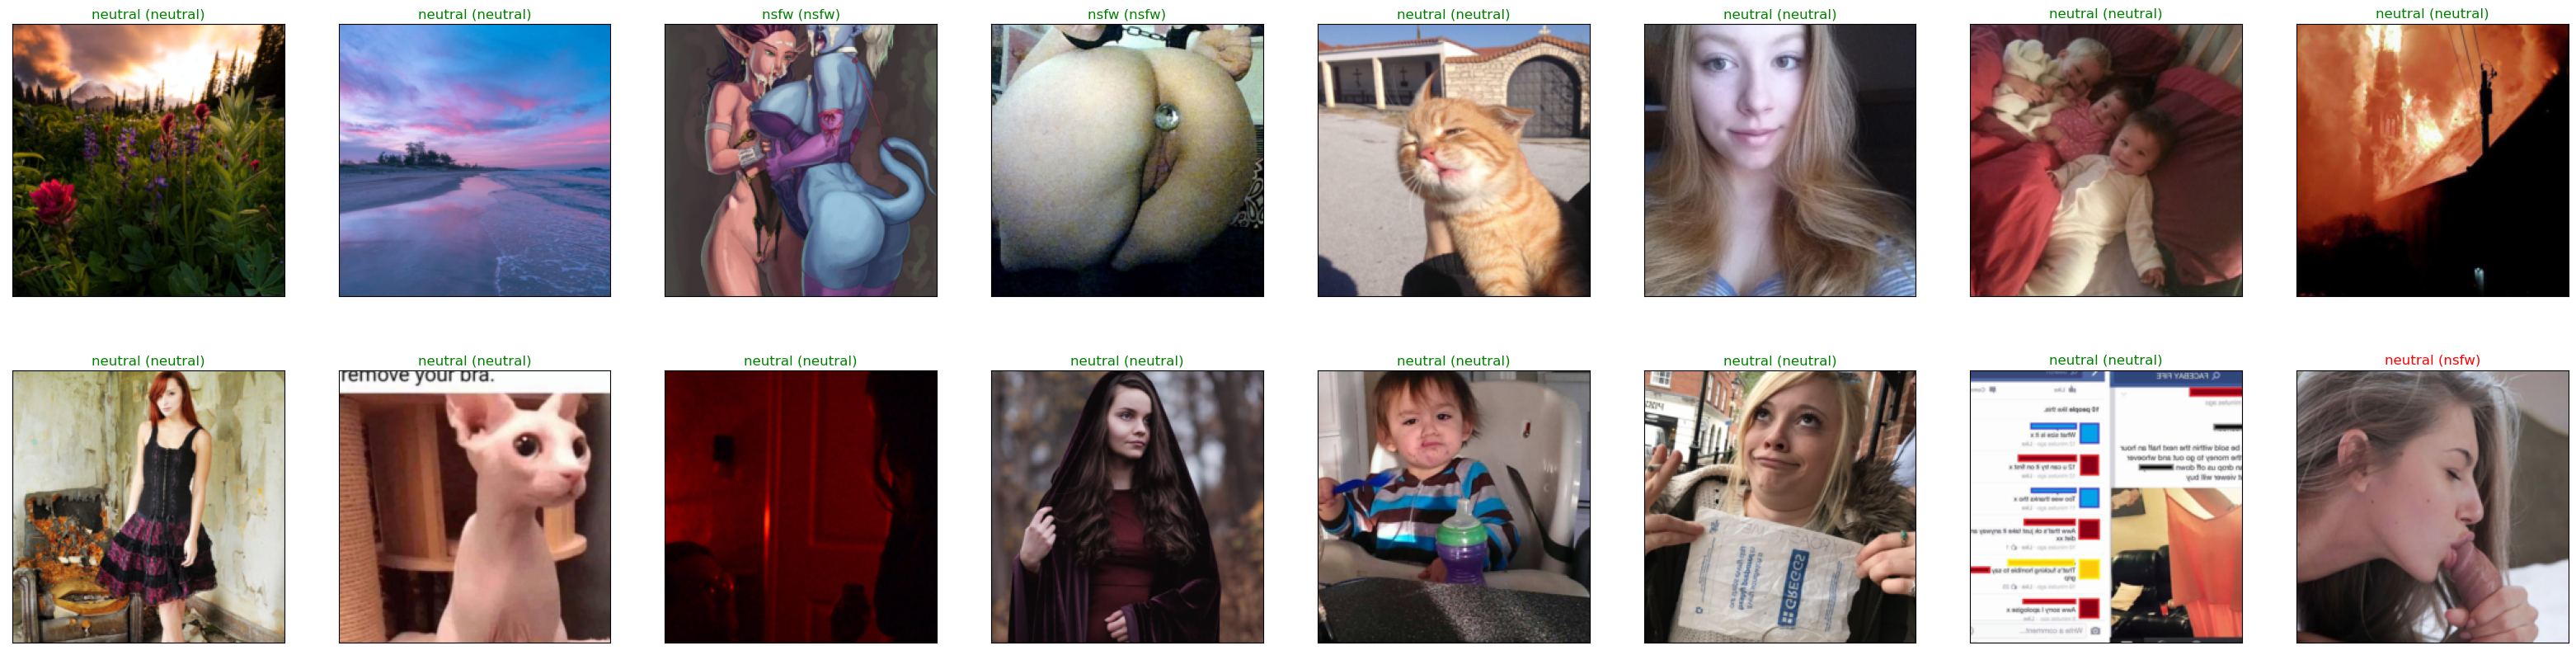

In [18]:
# Display a batch of predictions
def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = next(iter(dataloader))
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(40, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(trained_model, test_loader, device)

In [19]:
def test_model(model, test_dataloader):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    model.eval()   # Set model to evaluate mode
    all_preds = []
    all_labels = []

    for inputs, labels in test_dataloader:
                    
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            # Get predictions
            out = model(inputs)
            prob = torch.nn.functional.softmax(out, dim=1)
            prob = prob.cpu().numpy()
            labels = labels.cpu().numpy()
        
        all_preds.extend(prob)
        all_labels.extend(labels)

    return all_preds, all_labels

In [20]:
preds, true_labels = test_model(trained_model, test_loader)
preds_nsfw  = [x[1] for x in preds]
threshold = 0.5
pred_labels = [1 if x > threshold else 0 for x in preds_nsfw ]

# Resnet 18 only head training for 5 epochs

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
target_names=["neutral", "nsfw"]
print(classification_report(true_labels, pred_labels, target_names=target_names))

              precision    recall  f1-score   support

     neutral       0.92      0.97      0.94      8470
        nsfw       0.85      0.69      0.76      2301

    accuracy                           0.91     10771
   macro avg       0.88      0.83      0.85     10771
weighted avg       0.91      0.91      0.90     10771



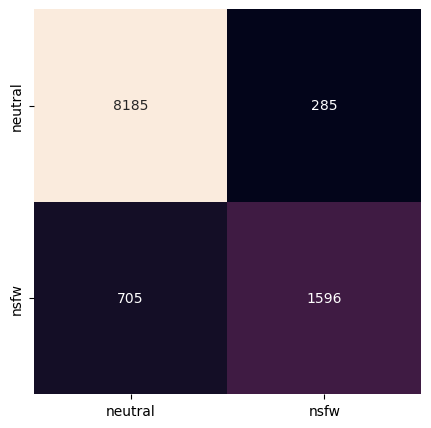

In [22]:
cmat = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(5,5))
sns.heatmap(cmat, annot = True, cbar = False, fmt="d", xticklabels=target_names, yticklabels=target_names);

# Resnet 152 only head training for 5 epochs

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
target_names=["neutral", "nsfw"]
print(classification_report(true_labels, pred_labels, target_names=target_names))

              precision    recall  f1-score   support

     neutral       0.93      0.98      0.95      8470
        nsfw       0.90      0.73      0.81      2301

    accuracy                           0.92     10771
   macro avg       0.91      0.86      0.88     10771
weighted avg       0.92      0.92      0.92     10771



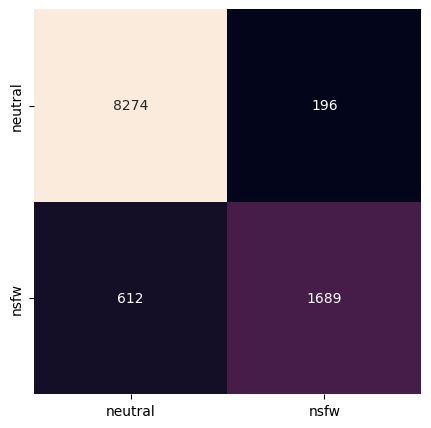

In [16]:
cmat = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(5,5))
sns.heatmap(cmat, annot = True, cbar = False, fmt="d", xticklabels=target_names, yticklabels=target_names);

# Resnet 152 full model training for 5 epochs

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
target_names=["neutral", "nsfw"]
print(classification_report(true_labels, pred_labels, target_names=target_names))

              precision    recall  f1-score   support

     neutral       0.93      0.98      0.95      8470
        nsfw       0.89      0.74      0.81      2301

    accuracy                           0.93     10771
   macro avg       0.91      0.86      0.88     10771
weighted avg       0.92      0.93      0.92     10771



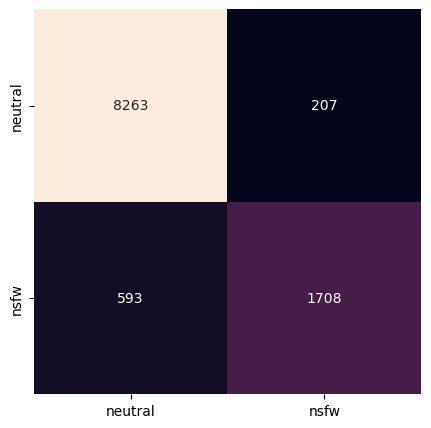

In [11]:
cmat = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(5,5))
sns.heatmap(cmat, annot = True, cbar = False, fmt="d", xticklabels=target_names, yticklabels=target_names);